# ANALYSIS - 2

# Where to Invest a Property in BOSTON to get maximum returns from Airbnb?

 Lets check average prices for these listings based on room type

In [3]:
# cleaning the data

import pandas as pd
import numpy as np

inputDF = pd.read_csv('listings.csv')
inputDF=inputDF[['id','name','summary','longitude','latitude','space','description','instant_bookable','neighborhood_overview','neighbourhood_cleansed','host_id','host_name','host_since',
                 'host_response_time','street', 'zipcode','review_scores_rating','property_type','room_type','accommodates','bathrooms','bedrooms','beds','reviews_per_month','amenities','cancellation_policy','number_of_reviews','price']]

# replacing NaN values with 0
inputDF.fillna(0, inplace=True)

#Extracting prices from the table
price = inputDF['price']

prices=[]

#clean the data to make it float
for p in price:
    p=float(p[1:].replace(',',''))
    prices.append(p)

#replace the price column with the new column
inputDF['price']=prices

#exclude the listings with 0 for price,beds,bedrooms,accomodates etc
inputDF = inputDF[inputDF.bathrooms >0]
inputDF = inputDF[inputDF.bedrooms > 0]
inputDF = inputDF[inputDF.beds > 0]
inputDF = inputDF[inputDF.price  > 0]
inputDF = inputDF[inputDF.review_scores_rating  > 0]
inputDF = inputDF[inputDF.reviews_per_month > 0]
inputDF = inputDF[inputDF.accommodates  > 0]

In [4]:
# Average prices for each type of listing

avgPrice_DF=inputDF.groupby('room_type').price.mean()
avgPrice_DF=avgPrice_DF.reset_index()
avgPrice_DF=avgPrice_DF.rename(columns={'price':'average_Price'})
avgPrice_DF

,room_type,average_Price
0,Entire home/apt,232.322326
1,Private room,89.505184
2,Shared room,69.903846


#得出结论： Entire home/Apartment 的平均房价是最高的

In [5]:
# Geographical Clusters to find out which area in Boston has maximum listings on Airbnb

# seggregating each type of property

home = inputDF[(inputDF.room_type == 'Entire home/apt')]
private = inputDF[(inputDF.room_type == 'Private room')]
shared = inputDF[(inputDF.room_type == 'Shared room')]

location_home = home[['latitude', 'longitude']]
location_private = private[['latitude', 'longitude']]
location_shared = shared[['latitude', 'longitude']]

In [6]:
# grouping neighbourhood by number of listings

neighbourhood_DF=home.groupby('neighbourhood_cleansed').id.count()
neighbourhood_DF=neighbourhood_DF.reset_index()
neighbourhood_DF=neighbourhood_DF.rename(columns={'id':'Number_Of_Listings'})
neighbourhood_DF=neighbourhood_DF.sort_values('Number_Of_Listings',ascending=[0])
neighbourhood_DF.head()

,neighbourhood_cleansed,Number_Of_Listings
21,South End,165
1,Back Bay,157
12,Jamaica Plain,125
10,Fenway,113
3,Beacon Hill,101


In [7]:
# grouping neighbourhood by average price of listings

neighbourhoodPrice_DF=home.groupby('neighbourhood_cleansed').price.mean()
neighbourhoodPrice_DF=neighbourhoodPrice_DF.reset_index()
neighbourhoodPrice_DF=neighbourhoodPrice_DF.rename(columns={'price':'Average_Price'})
neighbourhoodPrice_DF=neighbourhoodPrice_DF.sort_values('Average_Price',ascending=[0])
neighbourhoodPrice_DF.head()

,neighbourhood_cleansed,Average_Price
20,South Boston Waterfront,300.261905
2,Bay Village,300.083333
13,Leather District,284.500000
1,Back Bay,280.006369
6,Chinatown,275.193548


In [8]:
#Merging above two dataframes

mergeDF=pd.merge(neighbourhood_DF,neighbourhoodPrice_DF,on='neighbourhood_cleansed')
mergeDF.head()


,neighbourhood_cleansed,Number_Of_Listings,Average_Price
0,South End,165,245.290909
1,Back Bay,157,280.006369
2,Jamaica Plain,125,211.160000
3,Fenway,113,240.398230
4,Beacon Hill,101,255.178218


Text(0, 0.5, 'Number Of Listings')

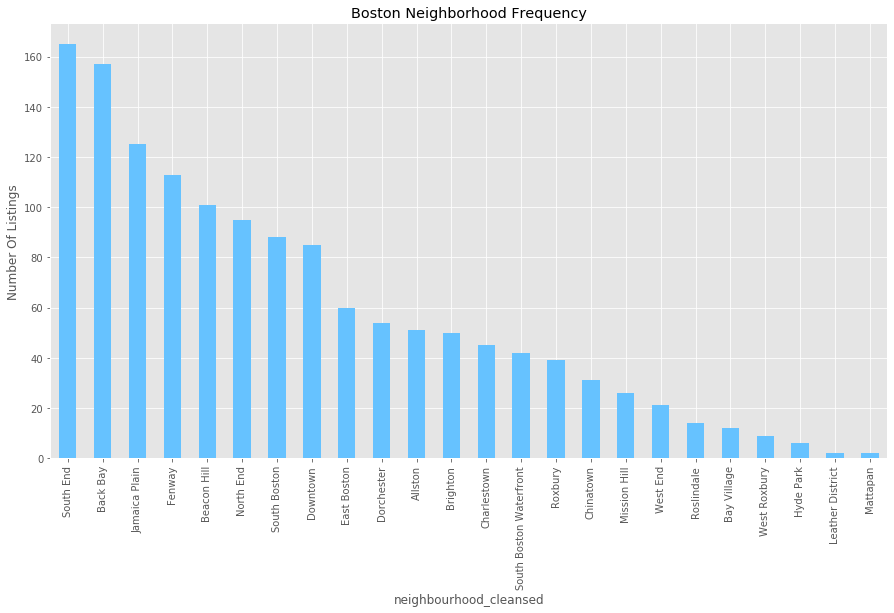

In [9]:
# visualizing the frequency of listings on the basis of neighbourhood where room type is entire apartment

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

objects = neighbourhood_DF['neighbourhood_cleansed']
y_pos = neighbourhood_DF['Number_Of_Listings']

neighbourhood_DF.plot(kind='bar', 
           x='neighbourhood_cleansed',
           y='Number_Of_Listings',
           color = '#66c2ff', 
           figsize =(15,8), 
           title = 'Boston Neighborhood Frequency', 
           legend = False)

plt.ylabel('Number Of Listings')

#得出结论：在Boston民宿数量最多的是South End ，back bay 和Jamaica plain.

Text(0, 0.5, 'Average Price')

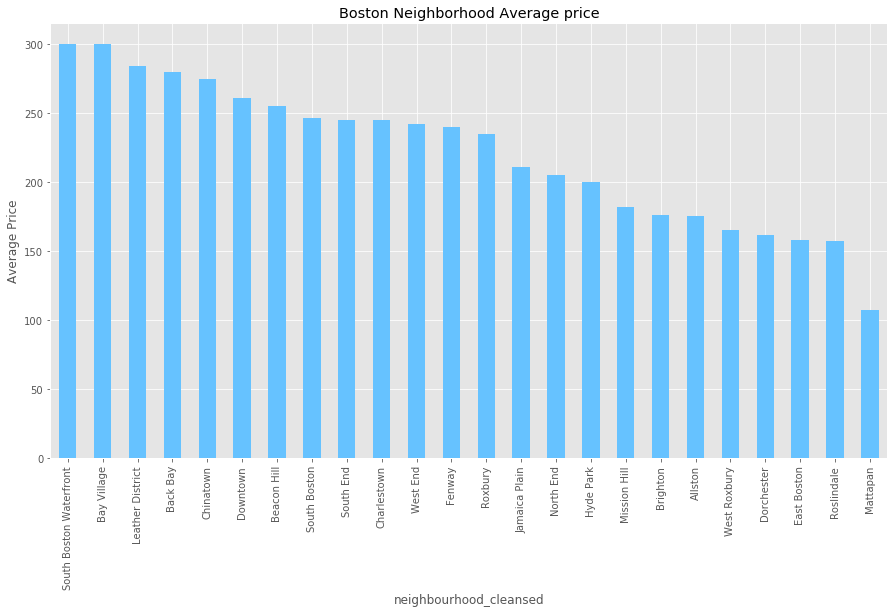

In [10]:
# Now lets visualize average price of these listings on the basis of neighbourhood where room type is entire apartment

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

objects = neighbourhoodPrice_DF['neighbourhood_cleansed']
y_pos = neighbourhoodPrice_DF['Average_Price']

neighbourhoodPrice_DF.plot(kind='bar', 
           x='neighbourhood_cleansed',
           y='Average_Price',
           color = '#66c2ff', 
           figsize =(15,8), 
           title = 'Boston Neighborhood Average price', 
           legend = False)

plt.ylabel('Average Price')

#得出结论：'Back Bay' 和 'South Boston'可以被认为是民宿数量最多的地区，并且平均价格也是最高的。

In [22]:
# Let's look at the differences between the words used in listings for Airbnb locations in different Boston neighborhoods

import re
import nltk
from nltk.corpus import stopwords
from collections import Counter

uniqueNeighborhoods = inputDF.neighbourhood_cleansed.unique().tolist()

#function to clean the data and compile a list of most common words
def cleanData(neighbrhood_name,descrip):
    p = re.sub('[^a-zA-Z]+',' ', descrip)
    cmn_words=['The','I','Boston','room']
    descrip_data=nltk.word_tokenize(p)
    filtered_data=[word.lower() for word in descrip_data if word not in cmn_words if word not in stopwords.words('english')] 
    wnl = nltk.WordNetLemmatizer() 
    counts=Counter([wnl.lemmatize(data) for data in filtered_data])
    commn_words=[]
    for w in counts.most_common(5):
        commn_words.append(w[0])
    return ' '.join(commn_words)

summ={}
for n in uniqueNeighborhoods:
    text=''
    for index,row in inputDF.iterrows():
        if row['neighbourhood_cleansed']==n:
            if ((row['description']!=0) & (row['space']!=0) & (row['neighborhood_overview']!=0)):
                text =text+row['description']+row['space']+row['neighborhood_overview']
    summ[n]=text

final_DF_neighbrhood=pd.DataFrame(columns=['neighborhood','top 5 words in description'])
for a in summ.items():
    top5words=cleanData(a[0],a[1])
    final_DF_neighbrhood=final_DF_neighbrhood.append(pd.Series([a[0],top5words],index=['neighborhood','top 5 words in description']),ignore_index=True)

final_DF_neighbrhood.to_csv('top_words_description.csv')

In [15]:
final_DF_neighbrhood.head()

,neighborhood,top 5 words in description
0,Roslindale,roslindale minute guest house neighborhood
1,Jamaica Plain,jamaica walk minute neighborhood bedroom
2,Mission Hill,apartment bed bedroom walk medical
3,Longwood Medical Area,longwood bathroom access kitchen medical
4,Bay Village,walk bay bed arlington bedroom
